In [1]:
# %% [Imports & Setup]
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


In [ ]:
# %% [Data Loading & Cleaning]

df = pd.read_csv(r"D:\boldtek_internship\clv_data.csv", encoding="ISO-8859-1")
# Display first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:


# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Drop missing values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Outlier Removal for 'TotalPrice' using the IQR method
Q1 = df['TotalPrice'].quantile(0.25)
Q3 = df['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['TotalPrice'] >= lower_bound) & (df['TotalPrice'] <= upper_bound)]

# Basic dataset information
print(df.info())




<class 'pandas.core.frame.DataFrame'>
Index: 368666 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    368666 non-null  object        
 1   StockCode    368666 non-null  object        
 2   Description  368666 non-null  object        
 3   Quantity     368666 non-null  int64         
 4   InvoiceDate  368666 non-null  datetime64[ns]
 5   UnitPrice    368666 non-null  float64       
 6   CustomerID   368666 non-null  float64       
 7   Country      368666 non-null  object        
 8   TotalPrice   368666 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 28.1+ MB
None


In [4]:
print("Missing values per column:\n", df.isnull().sum())
print(df.describe())

Missing values per column:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64
            Quantity                    InvoiceDate      UnitPrice  \
count  368666.000000                         368666  368666.000000   
mean        7.723207  2011-07-11 07:11:51.671485696       2.769694   
min      -720.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-07 12:29:00       1.250000   
50%         4.000000            2011-07-31 15:24:00       1.690000   
75%        12.000000            2011-10-20 15:15:00       3.750000   
max     12540.000000            2011-12-09 12:50:00      40.460000   
std        23.142696                            NaN       2.889512   

          CustomerID     TotalPrice  
count  368666.000000  368666.000000  
mean    15307.097202      11.754021  
min     12347.000000     -19.050000  
25%     13982.000000   

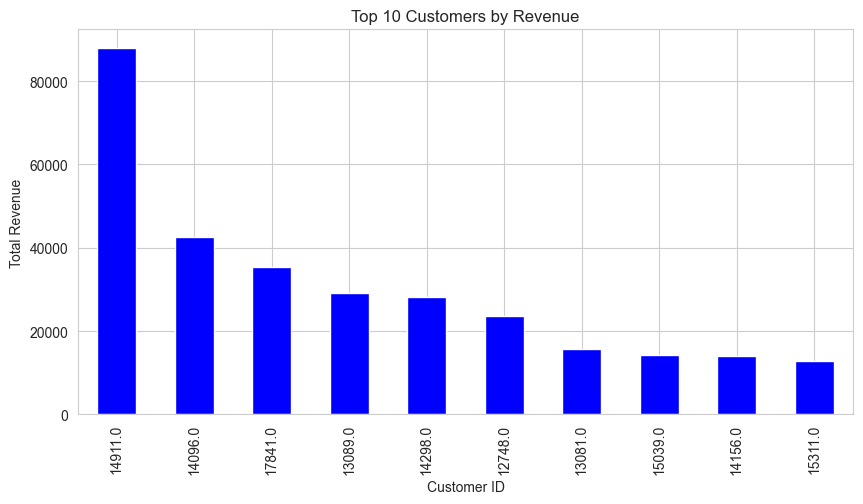

In [5]:
# %% [Exploratory Data Analysis (EDA)]
# Top 10 Customers by Revenue
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_customers.plot(kind="bar", color='blue')
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Total Revenue")
plt.show()



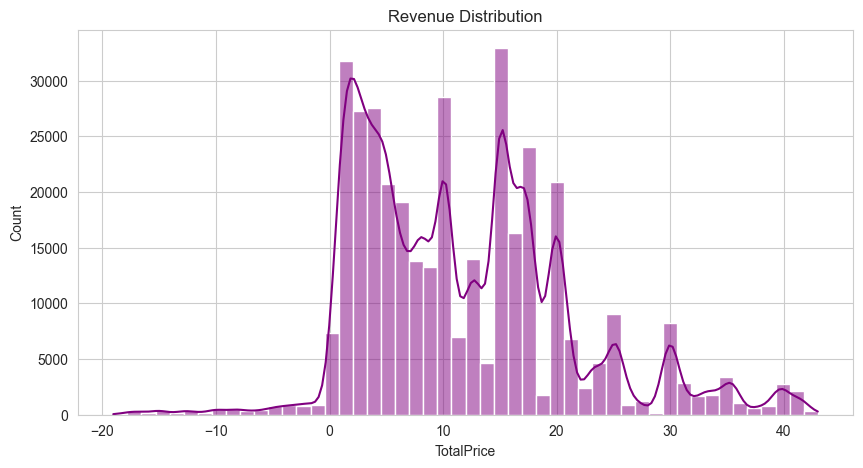

In [6]:
# Revenue Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['TotalPrice'], bins=50, kde=True, color='purple')
plt.title("Revenue Distribution")
plt.show()

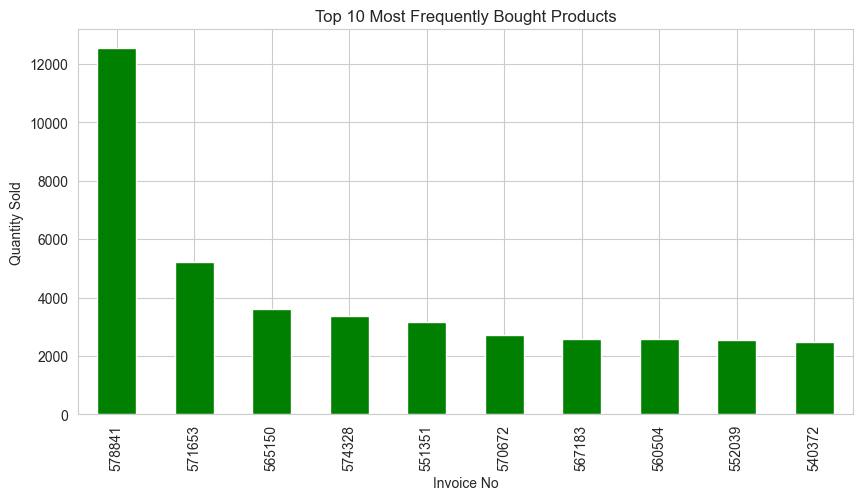

In [ ]:
# Top 10 Most Frequently Bought Products
top_products = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_products.plot(kind="bar", color='green')
plt.title("Top 10 Most Frequently Bought Products")
plt.xlabel("Product Code")
plt.ylabel("Quantity Sold")
plt.show()

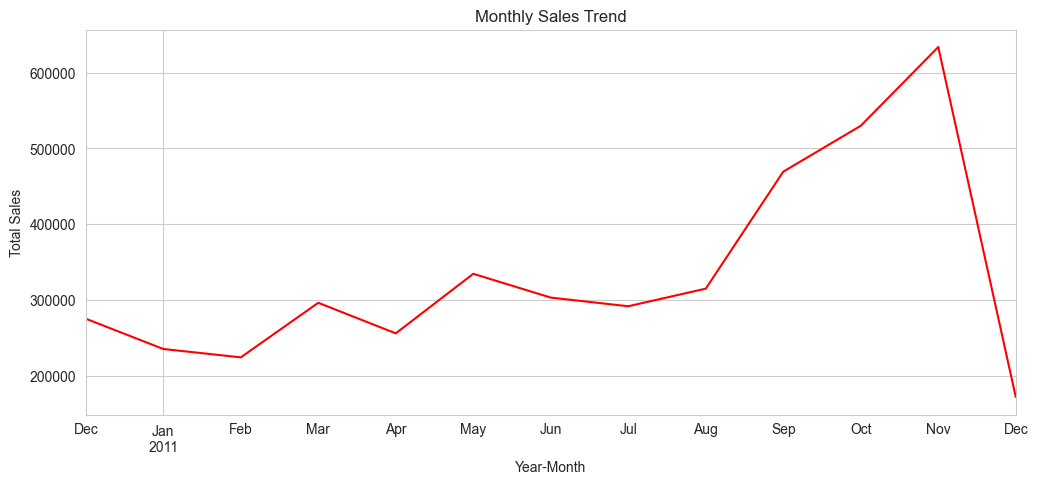

In [8]:
# Monthly Sales Trend
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['TotalPrice'].sum()
plt.figure(figsize=(12, 5))
monthly_sales.plot(color='red')
plt.title("Monthly Sales Trend")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.show()


In [ ]:
# %% [Customer-Level Aggregation & CLV Calculation]
# Defining snapshot date as the latest purchase date
snapshot_date = df['InvoiceDate'].max()

# Customer-level aggregation: Recency, Frequency, and Monetary Value
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'    # Monetary
}).reset_index()
customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Optionally, I have remove outliers in aggregated customer data (e.g., Monetary)
Q1_cust = customer_df['Monetary'].quantile(0.25)
Q3_cust = customer_df['Monetary'].quantile(0.75)
IQR_cust = Q3_cust - Q1_cust
lower_bound_cust = Q1_cust - 1.5 * IQR_cust
upper_bound_cust = Q3_cust + 1.5 * IQR_cust
customer_df = customer_df[(customer_df['Monetary'] >= lower_bound_cust) & (customer_df['Monetary'] <= upper_bound_cust)]

# Compute Average Order Value (AOV)
customer_df['AOV'] = customer_df['Monetary'] / customer_df['Frequency']

# Calculate overall purchase frequency
purchase_frequency = customer_df['Frequency'].sum() / customer_df.shape[0]

# Industry assumptions: Churn Rate (20%) and Profit Margin (10%)
churn_rate = 0.20
profit_margin = 0.10

# Calculating  CLV using an industry-standard formula
customer_df['CLV'] = (customer_df['AOV'] * purchase_frequency / churn_rate) * profit_margin

# Displaying top 10 customers by CLV
print(customer_df[['CustomerID', 'CLV']].sort_values(by='CLV', ascending=False).head(10))



      CustomerID          CLV
420      12891.0  1164.125455
1006     13739.0  1155.810273
2452     15769.0  1127.538655
364      12814.0  1108.690909
929      13631.0  1108.690909
1056     13811.0  1106.958580
1329     14195.0  1103.147455
72       12435.0  1080.973636
3543     17317.0  1057.691127
850      13514.0  1054.642227


In [ ]:
# %% [Model Preparation: Features, Train-Test Split, & Scaling]
# Defining Features and Target Variable
X = customer_df[['Recency', 'Frequency', 'Monetary', 'AOV']]
y = customer_df['CLV']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
# %% [Model Training & Evaluation]

# --- Baseline Model: Random Forest Regressor ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Regressor Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))
print("--------------------------------------------------")





Random Forest Regressor Metrics:
MAE: 0.4416919667428921
MSE: 7.556919203213832
R²: 0.9997704005359564
--------------------------------------------------


In [12]:
# --- Boosting Model 1: AdaBoost Regressor ---
ada_model = AdaBoostRegressor(n_estimators=100, random_state=42)  # BOOSTING
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
print("AdaBoost Regressor Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_ada))
print("MSE:", mean_squared_error(y_test, y_pred_ada))
print("R²:", r2_score(y_test, y_pred_ada))
print("--------------------------------------------------")

AdaBoost Regressor Metrics:
MAE: 13.771802066228153
MSE: 311.4039920105159
R²: 0.9905387119083898
--------------------------------------------------


In [13]:
# --- Boosting Model 2: Gradient Boosting Regressor ---
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)  # BOOSTING
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
print("Gradient Boosting Regressor Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("MSE:", mean_squared_error(y_test, y_pred_gbr))
print("R²:", r2_score(y_test, y_pred_gbr))
print("--------------------------------------------------")

Gradient Boosting Regressor Metrics:
MAE: 1.4749423030243645
MSE: 6.380118878280327
R²: 0.9998061548846038
--------------------------------------------------


In [ ]:
# 3: Histogram-Based Gradient Boosting Regressor ---
hgb_model = HistGradientBoostingRegressor(max_iter=100, random_state=42)  # BOOSTING
hgb_model.fit(X_train, y_train)
y_pred_hgb = hgb_model.predict(X_test)
print("Histogram-Based Gradient Boosting Regressor Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_hgb))
print("MSE:", mean_squared_error(y_test, y_pred_hgb))
print("R²:", r2_score(y_test, y_pred_hgb))
print("--------------------------------------------------")

Histogram-Based Gradient Boosting Regressor Metrics:
MAE: 2.90770374789426
MSE: 225.6654480006966
R²: 0.9931436787239877
--------------------------------------------------


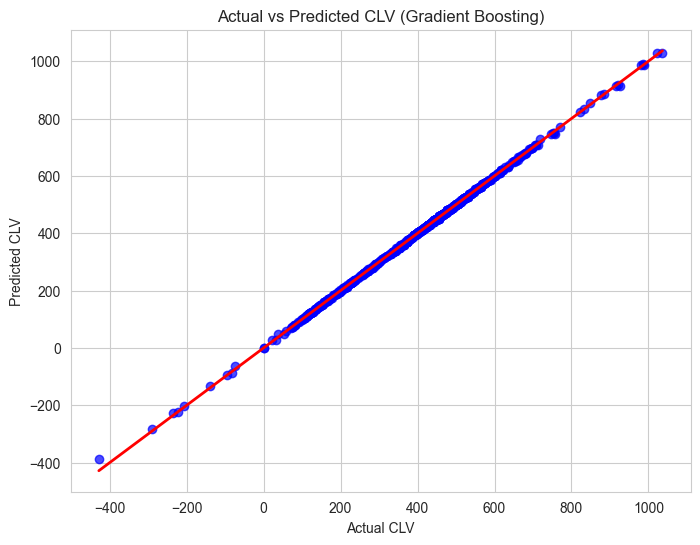

In [15]:
# %% [Visualization: Actual vs Predicted for Best Boosting Model]
# Here, we're plotting predictions of Gradient Boosting Regressor vs Actual CLV.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.7, color='blue')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV (Gradient Boosting)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.show()
